In [1]:
%env CUDA_VISIBLE_DEVICES=6
%env OMP_NUM_THREADS=16

env: CUDA_VISIBLE_DEVICES=6
env: OMP_NUM_THREADS=16


In [2]:
import torch
torch.set_grad_enabled(False)

In [3]:
from fast_hadamard_transform import hadamard_transform

class NoisyHadamarLinear(torch.nn.Module):
    def __init__(self, weight, bias, *, had_block_size = 2048, relative_mse = 0):
        super().__init__()

        weight = weight.detach().clone()
        if bias is not None:
            bias = bias.detach().clone()

        self.had_block_size = had_block_size

        self.out_features, self.in_features = weight.shape

        self.inner = torch.nn.Linear(self.in_features, self.out_features, bias=(bias is not None), dtype=weight.dtype,
                                     device=weight.device)

        assert self.in_features % self.had_block_size == 0, (self.in_features, self.had_block_size)
        weight = weight.reshape(self.out_features, self.in_features // self.had_block_size, self.had_block_size)
        weight = hadamard_transform(weight, scale=1 / (self.had_block_size ** 0.5))
        weight = weight.reshape(self.out_features, self.in_features)

        weight = weight + torch.randn_like(weight) * torch.norm(weight) * (relative_mse ** 0.5) / (weight.numel() ** 0.5)



        self.inner.weight.data = weight
        if bias is not None:
            self.inner.bias.data = bias

    def forward(self, input):
        input_shape = input.shape

        assert input.shape[-1] % self.had_block_size == 0

        input = input.reshape(-1, self.had_block_size)
        input = hadamard_transform(input, scale=1 / (self.had_block_size ** 0.5))
        input = input.reshape(input_shape)

        return self.inner(input)

In [4]:
from transformers import AutoModelForCausalLM

MODEL_PATH = '/mnt/LLM/hub/models--meta-llama--Meta-Llama-3.1-8B/snapshots/13f04ed6f85ef2aa2fd11b960a275c3e31a8069e/'
MODEL_SEQLEN = 8192
BASE_PPL = 5.606692790985107

model_pt_orig = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    trust_remote_code=True, torch_dtype="auto", device_map='cuda',
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
from eval import *

testloader = get_loaders(
    'wikitext2',
    seed=0,
    model_path=MODEL_PATH,
    seqlen=MODEL_SEQLEN,
    eval_mode=True,
    use_fast_tokenizer=False,
    trust_remote_code=False,
)

def eval_ppl(
    model,
    model_path=MODEL_PATH,
    model_seqlen=MODEL_SEQLEN,
    device = 'cuda:0',
    # ppl_datasets = ('wikitext2',),
    trust_remote_code=False,
    offload_activations=False,
):
    output = {}
    
    ppl = perplexity_eval(
        model,
        testloader,
        dataset_name='wikitext2',
        model_seqlen=model_seqlen,
        device=device,
        offload_activations=offload_activations,
    )
    output['wikitext2'] = ppl
    # make sure that the cache is released
    torch.cuda.empty_cache()
    
    return output

Token indices sequence length is longer than the specified maximum sequence length for this model (289076 > 131072). Running this sequence through the model will result in indexing errors


In [6]:
import copy
import torch

NF4_CODES = torch.tensor([
    -1.0, -0.6961928009986877, -0.5250730514526367, -0.39491748809814453, -0.28444138169288635, -0.18477343022823334,
    -0.09105003625154495, 0.0,
    0.07958029955625534, 0.16093020141124725, 0.24611230194568634, 0.33791524171829224, 0.44070982933044434,
    0.5626170039176941, 0.7229568362236023, 1.0,
], dtype=torch.float16)


def get_closest_idx(x, grid):
    _grid_len, = grid.shape
    input_shape = x.shape
    x = x.reshape(-1)

    output = (x[:, None] - grid[None, :]).abs().min(dim=1).indices
    assert output.shape == x.shape

    return output.reshape(input_shape)


def quantize_weight(weight, block_size=64, codes=NF4_CODES):
    out_dim, in_dim = weight.shape
    
    codes = copy.deepcopy(codes).to(weight.device)

    weight_groups = weight.reshape(-1, block_size)

    scales = weight_groups.abs().max(dim=1).values

    assert scales.shape == (out_dim * in_dim // block_size,)
    weight_quantized = get_closest_idx(
        weight_groups / scales[:, None],
        codes,
    ).reshape(out_dim, in_dim).to(weight.device)

    return weight_quantized, scales


def dequantize_weight(weight_quantized, scales, block_size = 64, codes=NF4_CODES):
    out_dim, in_dim = weight_quantized.shape
    
    codes = copy.deepcopy(codes).to(weight_quantized.device)

    return (
        codes[weight_quantized].reshape(-1, block_size) *
        scales[:, None]
    ).reshape(out_dim, in_dim)


def quantize_dequantize_weight(weight, block_size=64, codes=NF4_CODES):
    weight_quantized, scales = quantize_weight(weight, block_size=block_size, codes=codes)
    scales = scales.half()
    return dequantize_weight(weight_quantized, scales, block_size=block_size, codes=codes)

In [7]:
def get_module_by_path(model, path):
    if path == '':
        return model
    splitted = path.split('.', 1)
    if len(splitted) == 1:
        splitted.append('')
    next_name, suffix = splitted

    try:
        next_module = model[int(next_name)]
    except:
        next_module = getattr(model, next_name)

    return get_module_by_path(next_module, suffix)

def set_module_by_path(model, path, value):
    parts = path.split('.')
    prefix = '.'.join(parts[:-1])
    parent = get_module_by_path(model, prefix)
    setattr(parent, parts[-1], value)

In [8]:
layers = sorted([
    name for name, value in
    model_pt_orig.named_modules() if (
        isinstance(value, nn.Linear) and
        name.startswith('model.layers')
    )
])

In [9]:
model_pt_orig = model_pt_orig.half().cuda()
# eval_ppl(model_pt_orig)

In [10]:
nf4 = [-1.0, -0.6961928009986877, -0.5250730514526367, -0.39491748809814453, -0.28444138169288635, -0.18477343022823334, -0.09105003625154495, 0.0, 0.07958029955625534, 0.16093020141124725, 0.24611230194568634, 0.33791524171829224, 0.44070982933044434, 0.5626170039176941, 0.7229568362236023, 1.0]

nf4 = torch.tensor(nf4)

In [11]:
af4 = [-1.0, -0.7538047432899475, -0.5884406566619873, -0.4564161002635956, -0.34217405319213867, -0.23839078843593597, -0.14082424342632294, -0.04659047722816467, 0.04659047722816467, 0.14082424342632294, 0.23839078843593597, 0.34217405319213867, 0.4564161002635956, 0.5884406566619873, 0.7538047432899475, 1.0]

af4 = torch.tensor(af4)

In [12]:
eden = [-1.0, -0.7571635522922257, -0.5921293132333142, -0.459721873596143, -0.34485254078744687, -0.24034312562105065, -0.14200753146729223, -0.046986576840512384, 0.046986576840512384, 0.14200753146729223, 0.24034312562105065, 0.34485254078744687, 0.459721873596143, 0.5921293132333142, 0.7571635522922257, 1.0]

eden = torch.tensor(eden)

In [13]:
codes_by_name = {
    'nf4': nf4,
    'af4': af4,
    'eden': eden,
}

In [48]:
import copy
import tqdm

def eval_ppl_increase(codes, do_hadamar, block_size):
    global model_pt_orig
    model_pt_orig = model_pt_orig.float().cuda()
    model_pt = copy.deepcopy(model_pt_orig).cuda()
    
    for layer in layers:
        linear = get_module_by_path(model_pt, layer)

        if do_hadamar:
            new_linear = NoisyHadamarLinear(linear.weight, linear.bias)
            new_linear.inner.weight.data = quantize_dequantize_weight(new_linear.inner.weight, codes=codes, block_size=block_size).cuda()
            set_module_by_path(model_pt, layer, new_linear)
            continue
            
        linear.weight.data = quantize_dequantize_weight(linear.weight, codes=codes, block_size=block_size).cuda()        
    
    model_pt = model_pt.half().cuda()
    return eval_ppl(model_pt)['wikitext2'] - BASE_PPL

In [15]:
import itertools

In [16]:
data_lines = []

In [47]:
# data_lines = [line for line in data_lines if line['hadamard'] == True]

In [49]:
for block_size, do_hadamard, (name, codes) in itertools.product((8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096), (False,), sorted(codes_by_name.items())):
    data_lines.append({
        'name': name,
        'hadamard': do_hadamard,
        'block_size': block_size,
        'ppl_increase': eval_ppl_increase(codes, do_hadamard, block_size),
    })
    print(data_lines[-1])

{'name': 'af4', 'hadamard': False, 'block_size': 8, 'ppl_increase': 0.21720600128173828}
{'name': 'eden', 'hadamard': False, 'block_size': 8, 'ppl_increase': 0.22013187408447266}
{'name': 'nf4', 'hadamard': False, 'block_size': 8, 'ppl_increase': 0.20357227325439453}
{'name': 'af4', 'hadamard': False, 'block_size': 16, 'ppl_increase': 0.3084235191345215}
{'name': 'eden', 'hadamard': False, 'block_size': 16, 'ppl_increase': 0.31238651275634766}
{'name': 'nf4', 'hadamard': False, 'block_size': 16, 'ppl_increase': 0.2581357955932617}
{'name': 'af4', 'hadamard': False, 'block_size': 32, 'ppl_increase': 0.40073537826538086}
{'name': 'eden', 'hadamard': False, 'block_size': 32, 'ppl_increase': 0.40241146087646484}
{'name': 'nf4', 'hadamard': False, 'block_size': 32, 'ppl_increase': 0.31139516830444336}
{'name': 'af4', 'hadamard': False, 'block_size': 64, 'ppl_increase': 0.5006189346313477}
{'name': 'eden', 'hadamard': False, 'block_size': 64, 'ppl_increase': 0.5040278434753418}
{'name': 'nf4

In [50]:
import pandas as pd

data = pd.DataFrame(data_lines)

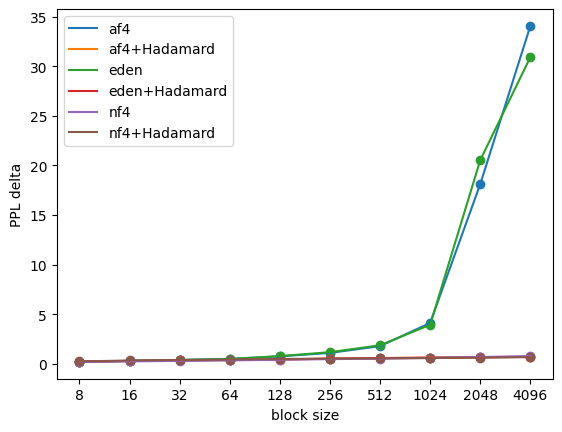

In [51]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots()

for name, hadamard in sorted(set(tuple(v) for v in data[['name', 'hadamard']].values)):
    to_plot = data
    to_plot = to_plot[to_plot['name'] == name]
    to_plot = to_plot[to_plot['hadamard'] == hadamard]
    label = name
    if hadamard:
        label += '+Hadamard'
    
    plt.plot(to_plot['block_size'], to_plot['ppl_increase'], label=label)
    plt.scatter(to_plot['block_size'], to_plot['ppl_increase'])

plt.ylabel('PPL delta')
plt.xscale('log')
plt.minorticks_off() 
ax.xaxis.set_ticks([8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.f'))
plt.xlabel('block size')
plt.legend()

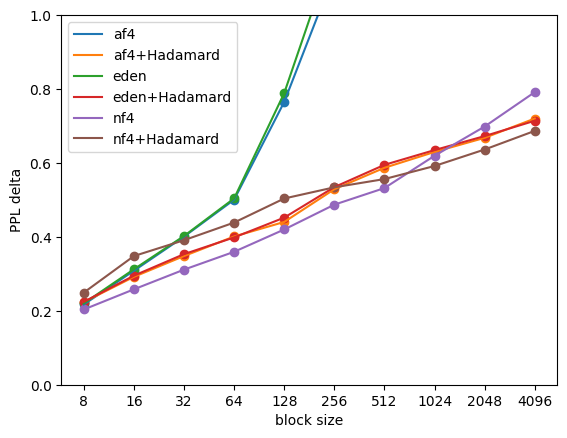

In [52]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots()

for name, hadamard in sorted(set(tuple(v) for v in data[['name', 'hadamard']].values)):
    to_plot = data
    to_plot = to_plot[to_plot['name'] == name]
    to_plot = to_plot[to_plot['hadamard'] == hadamard]
    label = name
    if hadamard:
        label += '+Hadamard'
    
    plt.plot(to_plot['block_size'], to_plot['ppl_increase'], label=label)
    plt.scatter(to_plot['block_size'], to_plot['ppl_increase'])

plt.ylabel('PPL delta')
plt.xscale('log')
plt.minorticks_off() 
ax.xaxis.set_ticks([8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.f'))
plt.xlabel('block size')
plt.ylim([0, 1])
plt.legend()

In [20]:
# af4+hadamar 0.40107011795043945
# eden+hadamar 0.3985562324523926
# nf4+hadamar 0.4387364387512207

In [21]:
# af4 0.5006189346313477
# eden 0.5040278434753418
# nf4 0.35964202880859375
# af4+hadamar 0.40241146087646484
# eden+hadamar 0.40056753158569336
# nf4+hadamar 0.41819286346435547

In [22]:
# model_pt(torch.tensor([0])[:, None].cuda());

In [53]:
!git add *.ipynb *.py && git commit -m upd && git push

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[galqiwi 4be5283] upd
 1 file changed, 691 insertions(+), 664 deletions(-)
 rewrite Vladimir/2024-09-27/bnb-blocksize/bnb.ipynb (74%)
Counting objects: 6, done.
Delta compression using up to 255 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (6/6), 86.10 KiB | 10.76 MiB/s, done.
Total 6 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:galqiwi/linear-layer-compression.git
   2f41fd7..4be5283  galqiwi -> galqiwi
